In [16]:
import gym
env = gym.make('CartPole-v0')
from matplotlib import pyplot as plt

In [10]:
#get an initial state
state1 = env.reset()

#sample a random action
action = env.action_space.sample()


#get the current state, reward
# done : bool
# state : row vector size 4 
# reward : float
state, reward, done, info = env.step(action)

# have the model return a softmax given the state
pred = model(torch.from_numpy(state1).float())   

#pick option 0 or 1 from the two actions in the action distribution
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())   


state2, reward, done, info = env.step(action)  
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())   
action

p=pred.data.numpy()
p

np.random.choice(np.array([0,1, 2, 3, 4]), p=[0.1, 0, 0.2, 0.7, 0])

In [66]:
import gym
import numpy as np
import torch
env = gym.make('CartPole-v0')


In [67]:

l1 = 4                          
l2 = 150                        
l3 = 2                          

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax()          
)
 
learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [87]:
def discount_rewards(rewards, gamma=0.99):    
    lenr = len(rewards)
    
    # computes the exponential decay
    
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards
    
    #normalize the return between 0 and 1 to improve stability
    disc_return /= disc_return.max()
    return disc_return

In [88]:
# pred : array of action probabilities
# r : discounted rewards
def loss_fn(preds, r):  
    # log of probabilities, multiplies by the discounted rewards, sums them all, and flips the sign
    return -1 * torch.sum(r * torch.log(preds))

In [96]:
MAX_DUR = 600
MAX_EPISODES = 1000
gamma = 0.99
score = []
expectation = 0.0

for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = []   # list of state, action, rewards
    
    for t in range(MAX_DUR):
        # get the action probability space
        act_prob = model(torch.from_numpy(curr_state).float())
        
        # pick between the 2 actions in the probability space aka select action stochastically
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())
        
        prev_state = curr_state
        
        # ignore the reward, take an action
        curr_state, _, done, info = env.step(action)  
        
        # keep track of the state, action, and timestep
        transitions.append((prev_state, action, t+1)) 
        
        # break loop if the game is over
        if done:
            break
            
    #store the episode length
    ep_len = len(transitions)

    score.append(ep_len)
        
    # get the rewards and reverse the order to put last as first        
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) 

    # computes the discount version of the rewards
    disc_rewards = discount_rewards(reward_batch)

    # collects the states into a single tensor
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) 

    # collects the actions into a single tensor
    action_batch = torch.Tensor([a for (s,a,r) in transitions])  

    # recompute the action probabilities for all the states in the episode
    pred_batch = model(state_batch)

    # turn the action vector into a long type, change the rows into a column vector with the
    # , gather will match the pred_batch to the column that the action_batch lists, then 
    # squeeze will turn it into a row vector

    # aka get the actual actions using the probability distributions 
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze()

    # 
    loss = loss_fn(prob_batch, disc_rewards)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [71]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

In [72]:
score = np.array(score)
avg_score = running_mean(score, 50)

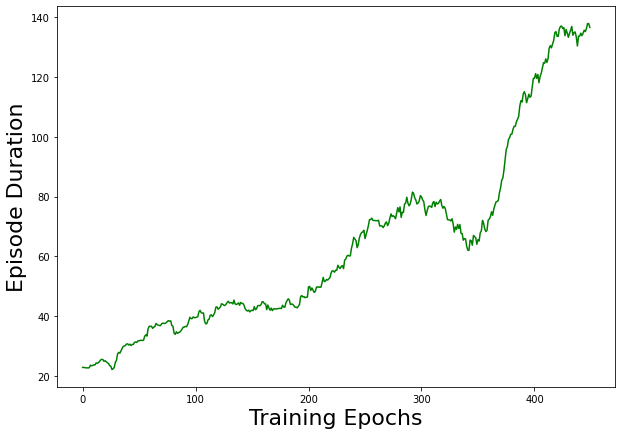

In [73]:
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')

In [81]:
score = []
games = 100
done = False
state1 = env.reset()
for i in range(games):
    t=0
    while not done: #F
        pred = model(torch.from_numpy(state1).float()) #G
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) #H
        state2, reward, done, info = env.step(action) #I
        state1 = state2 
        t += 1
        if t > MAX_DUR: #L
            break;
    state1 = env.reset()
    done = False
    score.append(t)
score = np.array(score)

In [82]:
score

array([200, 199, 200, 200, 197, 200, 172, 200, 200, 200, 200, 200, 200,
       200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 193, 200, 200,
       200, 197, 194, 171, 200, 144, 200, 200, 200, 157, 200, 200, 175,
       200, 200, 200, 200, 200, 200, 181, 200, 200, 200, 200, 200, 200,
       103, 200, 195, 198, 200, 200, 197, 200, 200, 200, 200, 200, 200,
       200, 200, 191, 200, 200, 137, 200, 200, 200, 122, 200, 187, 200,
       184, 200, 200, 200, 200, 200, 200, 188, 200, 193, 200, 200, 200,
       200, 200, 200, 200, 200, 196, 200, 200, 200])

In [80]:
np.mean(score)

189.11

In [98]:
state1 = env.reset()
MAX_DUR = 600
t=0
done = False
while not done: #F
    env.render()
    pred = model(torch.from_numpy(state1).float()) #G
    action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) #H
    state2, reward, done, info = env.step(action) #I
    state1 = state2 
    t += 1
    if t > MAX_DUR: #L
        break;

In [91]:
#watch a test
import gym
env = gym.make('CartPole-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

[ 0.0268312   0.02659473  0.0457569  -0.01449724]
[ 0.0273631  -0.16915255  0.04546696  0.29226419]
[0.02398005 0.02529263 0.05131224 0.01426052]
[ 0.0244859   0.21964258  0.05159745 -0.26180153]
[ 0.02887875  0.41399148  0.04636142 -0.53777399]
[ 0.03715858  0.21824943  0.03560594 -0.23085102]
[ 0.04152357  0.41284498  0.03098892 -0.5120934 ]
[ 0.04978047  0.60751704  0.02074705 -0.79485201]
[ 0.06193081  0.80234819  0.00485001 -1.08093664]
[ 0.07797777  0.99740578 -0.01676872 -1.37209368]
[ 0.09792589  0.80249748 -0.0442106  -1.08470212]
[ 0.11397584  0.99817395 -0.06590464 -1.3909237 ]
[ 0.13393932  0.80393177 -0.09372311 -1.1195549 ]
[ 0.15001795  0.61015583 -0.11611421 -0.85768093]
[ 0.16222107  0.80665198 -0.13326783 -1.18450136]
[ 0.17835411  1.00322681 -0.15695786 -1.51581392]
[ 0.19841865  0.81031358 -0.18727413 -1.27595755]
Episode finished after 17 timesteps
[ 0.03915521 -0.04095312  0.0042208   0.02084425]
[ 0.03833615 -0.23613534  0.00463768  0.31485589]
[ 0.03361344 -0.43

[0.05854114 0.2060194  0.07267825 0.09580821]
[0.06266153 0.00993511 0.07459442 0.41050679]
[0.06286023 0.20392465 0.08280455 0.1422421 ]
[0.06693873 0.00772042 0.0856494  0.45985677]
[0.06709313 0.20153391 0.09484653 0.19535238]
[0.07112381 0.00519224 0.09875358 0.51638427]
[0.07122766 0.19879505 0.10908126 0.25638133]
[0.07520356 0.00229848 0.11420889 0.58138071]
[ 0.07524953 -0.19422286  0.1258365   0.90774676]
[ 0.07136507 -0.00100839  0.14399144  0.65711504]
[ 0.0713449  -0.19781001  0.15713374  0.9914498 ]
[ 0.0673887  -0.39464581  0.17696274  1.32907338]
[ 0.05949579 -0.20214224  0.2035442   1.09658348]
Episode finished after 36 timesteps
[-0.03675869  0.00735285 -0.03673378 -0.04032891]
[-0.03661163 -0.18722361 -0.03754036  0.24054159]
[-0.04035611  0.00841394 -0.03272952 -0.06374224]
[-0.04018783 -0.18622384 -0.03400437  0.2184373 ]
[-0.0439123  -0.38084362 -0.02963562  0.50020285]
[-0.05152918 -0.18531669 -0.01963157  0.19832964]
[-0.05523551 -0.38015243 -0.01566497  0.484755

[ 0.03857956  0.02804363 -0.06498303 -0.10398288]
[ 0.03914044 -0.16608978 -0.06706269  0.16751103]
[ 0.03581864  0.02992483 -0.06371247 -0.14555161]
[ 0.03641714  0.22589859 -0.0666235  -0.45763462]
[ 0.04093511  0.42189603 -0.07577619 -0.77055136]
[ 0.04937303  0.22789417 -0.09118722 -0.50264053]
[ 0.05393091  0.03416784 -0.10124003 -0.24003024]
[ 0.05461427  0.23057934 -0.10604063 -0.56285268]
[ 0.05922586  0.42701696 -0.11729769 -0.88697157]
[ 0.0677662   0.23366578 -0.13503712 -0.63334421]
[ 0.07243951  0.43038733 -0.147704   -0.96532057]
[ 0.08104726  0.23752484 -0.16701041 -0.72244404]
[ 0.08579776  0.43451472 -0.1814593  -1.06269064]
[ 0.09448805  0.63151403 -0.20271311 -1.40639466]
Episode finished after 20 timesteps
[-0.02735636  0.04081701 -0.03500362  0.02853181]
[-0.02654002  0.236423   -0.03443299 -0.2749864 ]
[-0.02181156  0.43201887 -0.03993271 -0.57832761]
[-0.01317118  0.23747867 -0.05149927 -0.29848703]
[-0.00842161  0.43329545 -0.05746901 -0.60695687]
[ 2.44298696e-

In [99]:
env.close()